# Prediction of Pulsars and Non-pulsars via Classification - Project Report

## Group 10 Members
- Nishant Molleti:   21147343
- Ajitesh Taneja: &nbsp; 69832913
- Asteria Xu: &nbsp; &nbsp; &nbsp; &nbsp; 56376452
- Audrey Tsung: &nbsp; 60770633

## Introduction

Pulsars are rotating neutron stars that emit radio waves at regular intervals, and their detection is important in fields such as Astrophysics and Radio Astronomy. However, pulsars are challenging to detect due to interference and noise at radio frequencies, thus giving false signals. To improve detection, machine learning techniques have been employed. 

The question that we want to address is: Is a new observation a pulsar or non-pulsar based on the statistics of the integrated profile as our predictors? 

The dataset which we are using to answer this question is the HTRU2 dataset, which contains 17,898 observations of pulsars and non-pulsars, obtained from the High Time Resolution Universe Survey. Each observation has 8 features; mean, standard deviation, excess kurtosis and skewness for both the Integrated Profile and DM-SNR curve. Additionally, a binary label called 'class' is used to indicate whether an observation is a pulsar or not where 0 belongs to non-pulsar and 1 being pulsar. 


In [1]:
library(tidyverse)
library(repr)
library(recipes)
library(tidymodels)
library(cowplot)
library(GGally)
library(tidymodels)
library(ggplot2)
install.packages("themis")
library("themis")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘recipes’


The following object is masked from ‘package:stringr’:

    fixed


The following object is masked from ‘package:stats’:

    step


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::fil

## Preliminary Exploratory Data Analysis

Now, we will read the dataset from the web into R, and then clean our data.  Here, we notice that the class column has 0's and 1's. The 1's mean that the observation is a pulsar, and 0 means non-pulsar.

In [2]:
# Adding the column names to the dataset because they originally did not exist
columns <- c("mean_ip", "std_ip", "ek_ip", "sk_ip", "mean_dmsnr", "std_dmsnr", "ek_dmsnr", "sk_dmsnr", "class")

# reading the data, and converting class to factor type
pulsar_data <- read_csv("https://raw.githubusercontent.com/audst/dsci100-s005-group10/main/data/HTRU_2.csv", col_names = columns) |>
                    mutate(class = as.factor(class))

print("Table 1")
head(pulsar_data, 10)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): mean_ip, std_ip, ek_ip, sk_ip, mean_dmsnr, std_dmsnr, ek_dmsnr, sk_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 1"


mean_ip,std_ip,ek_ip,sk_ip,mean_dmsnr,std_dmsnr,ek_dmsnr,sk_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.1998328,19.110426,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.6772575,14.860146,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.1212375,21.744669,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.6429766,20.959280,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.1789298,11.468720,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.6362876,14.545074,10.621748,131.39400,0
119.48438,48.76506,0.03146022,-0.1121676,0.9991639,9.279612,19.206230,479.75657,0
130.38281,39.84406,-0.15832276,0.3895404,1.2207358,14.378941,13.539456,198.23646,0
107.25000,52.62708,0.45268802,0.1703474,2.3319398,14.486853,9.001004,107.97251,0


Next, we can select the columns that we plan to use as the predictors, namely mean_ip, std_ip, ek_ip, and sk_ip, along with the class column.

In [3]:
pulsar_data_pred <- pulsar_data |>
                        select(mean_dmsnr, std_dmsnr, ek_dmsnr, sk_dmsnr, class)

print("Table 2")
head(pulsar_data_pred, 5)

[1] "Table 2"


mean_dmsnr,std_dmsnr,ek_dmsnr,sk_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3.199833,19.11043,7.975532,74.24222,0
1.677258,14.86015,10.576487,127.39358,0
3.121237,21.74467,7.735822,63.17191,0
3.642977,20.95928,6.896499,53.59366,0
1.178930,11.46872,14.269573,252.56731,0


We now have to scale all the potential predictor variables so that the prediction is not influenced by the different scales of all the predictors, thus avoiding inaccurate predictions.

In [4]:
pulsar_scaled <- pulsar_data_pred |>
                    mutate(mean_dmsnr_scaled = scale(mean_dmsnr, center=TRUE)) |>
                    mutate(std_dmsnr_scaled = scale(std_dmsnr, center=TRUE)) |>
                    mutate(ek_dmsnr_scaled = scale(ek_dmsnr, center=TRUE)) |>
                    mutate(sk_dmsnr_scaled = scale(sk_dmsnr, center=TRUE)) |>
                    select(class:sk_dmsnr_scaled)

print("Table 3")
head(pulsar_scaled, 10)

[1] "Table 3"


class,mean_dmsnr_scaled,std_dmsnr_scaled,ek_dmsnr_scaled,sk_dmsnr_scaled
<fct>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
0,-0.3194313,-0.37061511,-0.07279575,-0.28743009
0,-0.3710915,-0.58890765,0.50441285,0.21157554
0,-0.3220980,-0.23532159,-0.12599257,-0.39136253
0,-0.3043957,-0.27565879,-0.31225666,-0.48128686
0,-0.3879995,-0.76308980,1.32398915,1.38675525
0,-0.3724816,-0.60508958,0.51445740,0.24913308
0,-0.3940989,-0.87552139,2.41954101,3.51969656
0,-0.3865811,-0.61362210,1.16196031,0.87667607
0,-0.3488785,-0.60807979,0.15477899,0.02924293


Now we can continue with splitting 75% of our data into training and and 25% testing.

In [5]:
set.seed(100)

pulsar_split <- pulsar_scaled |>
                    initial_split(prop=3/4, strata=class)
pulsar_training <- training(pulsar_split)
pulsar_testing <- testing(pulsar_split)

We can now see if we have any missing data in our training set

In [6]:
n_rows_missing_data <- pulsar_training |>
                          map_df(~sum(is.na(.)))

print("Table 4")
n_rows_missing_data

[1] "Table 4"


class,mean_dmsnr_scaled,std_dmsnr_scaled,ek_dmsnr_scaled,sk_dmsnr_scaled
<int>,<int>,<int>,<int>,<int>
0,0,0,0,0


Fortunately, we can see that we do not have empty data to deal with, so we can proceed to find out how many observations exist for each class in our training set.

In [7]:
class_counts <- pulsar_training |>
                    group_by(class) |>
                    dplyr::summarize(count = n())

print("Table 5")
class_counts

[1] "Table 5"


class,count
<fct>,<int>
0,12182
1,1241


Here, we notice that there is an overwhelming majority of observations with class 0, which shows how difficult it is to detect pulsars among the rest of the noise and radio frequencies. 
Now we find the means of all our predictor variables based on the two classes.

In [8]:
means <- pulsar_training |>
            group_by(class) |>
            summarize_at(vars("mean_dmsnr_scaled", "std_dmsnr_scaled", "ek_dmsnr_scaled", "sk_dmsnr_scaled"), mean)

print("Table 6")
means

[1] "Table 6"


class,mean_dmsnr_scaled,std_dmsnr_scaled,ek_dmsnr_scaled,sk_dmsnr_scaled
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
0,-0.1323968,-0.1607025,0.1322643,0.0910913
1,1.3121640,1.5650118,-1.2384155,-0.8136458


Above, we see that the means of the variables vary extensively for the different classes. This reaffirms our choice of predictor variables as the model will be able to predict the different classes with a greater accuracy and less indistinctness. 
Now we can create a series of plots to find out the relation of the different variables with the class. Each plot matches one predictor variable with another to demonstrate any visual trends that are otherwise unnoticeable. 

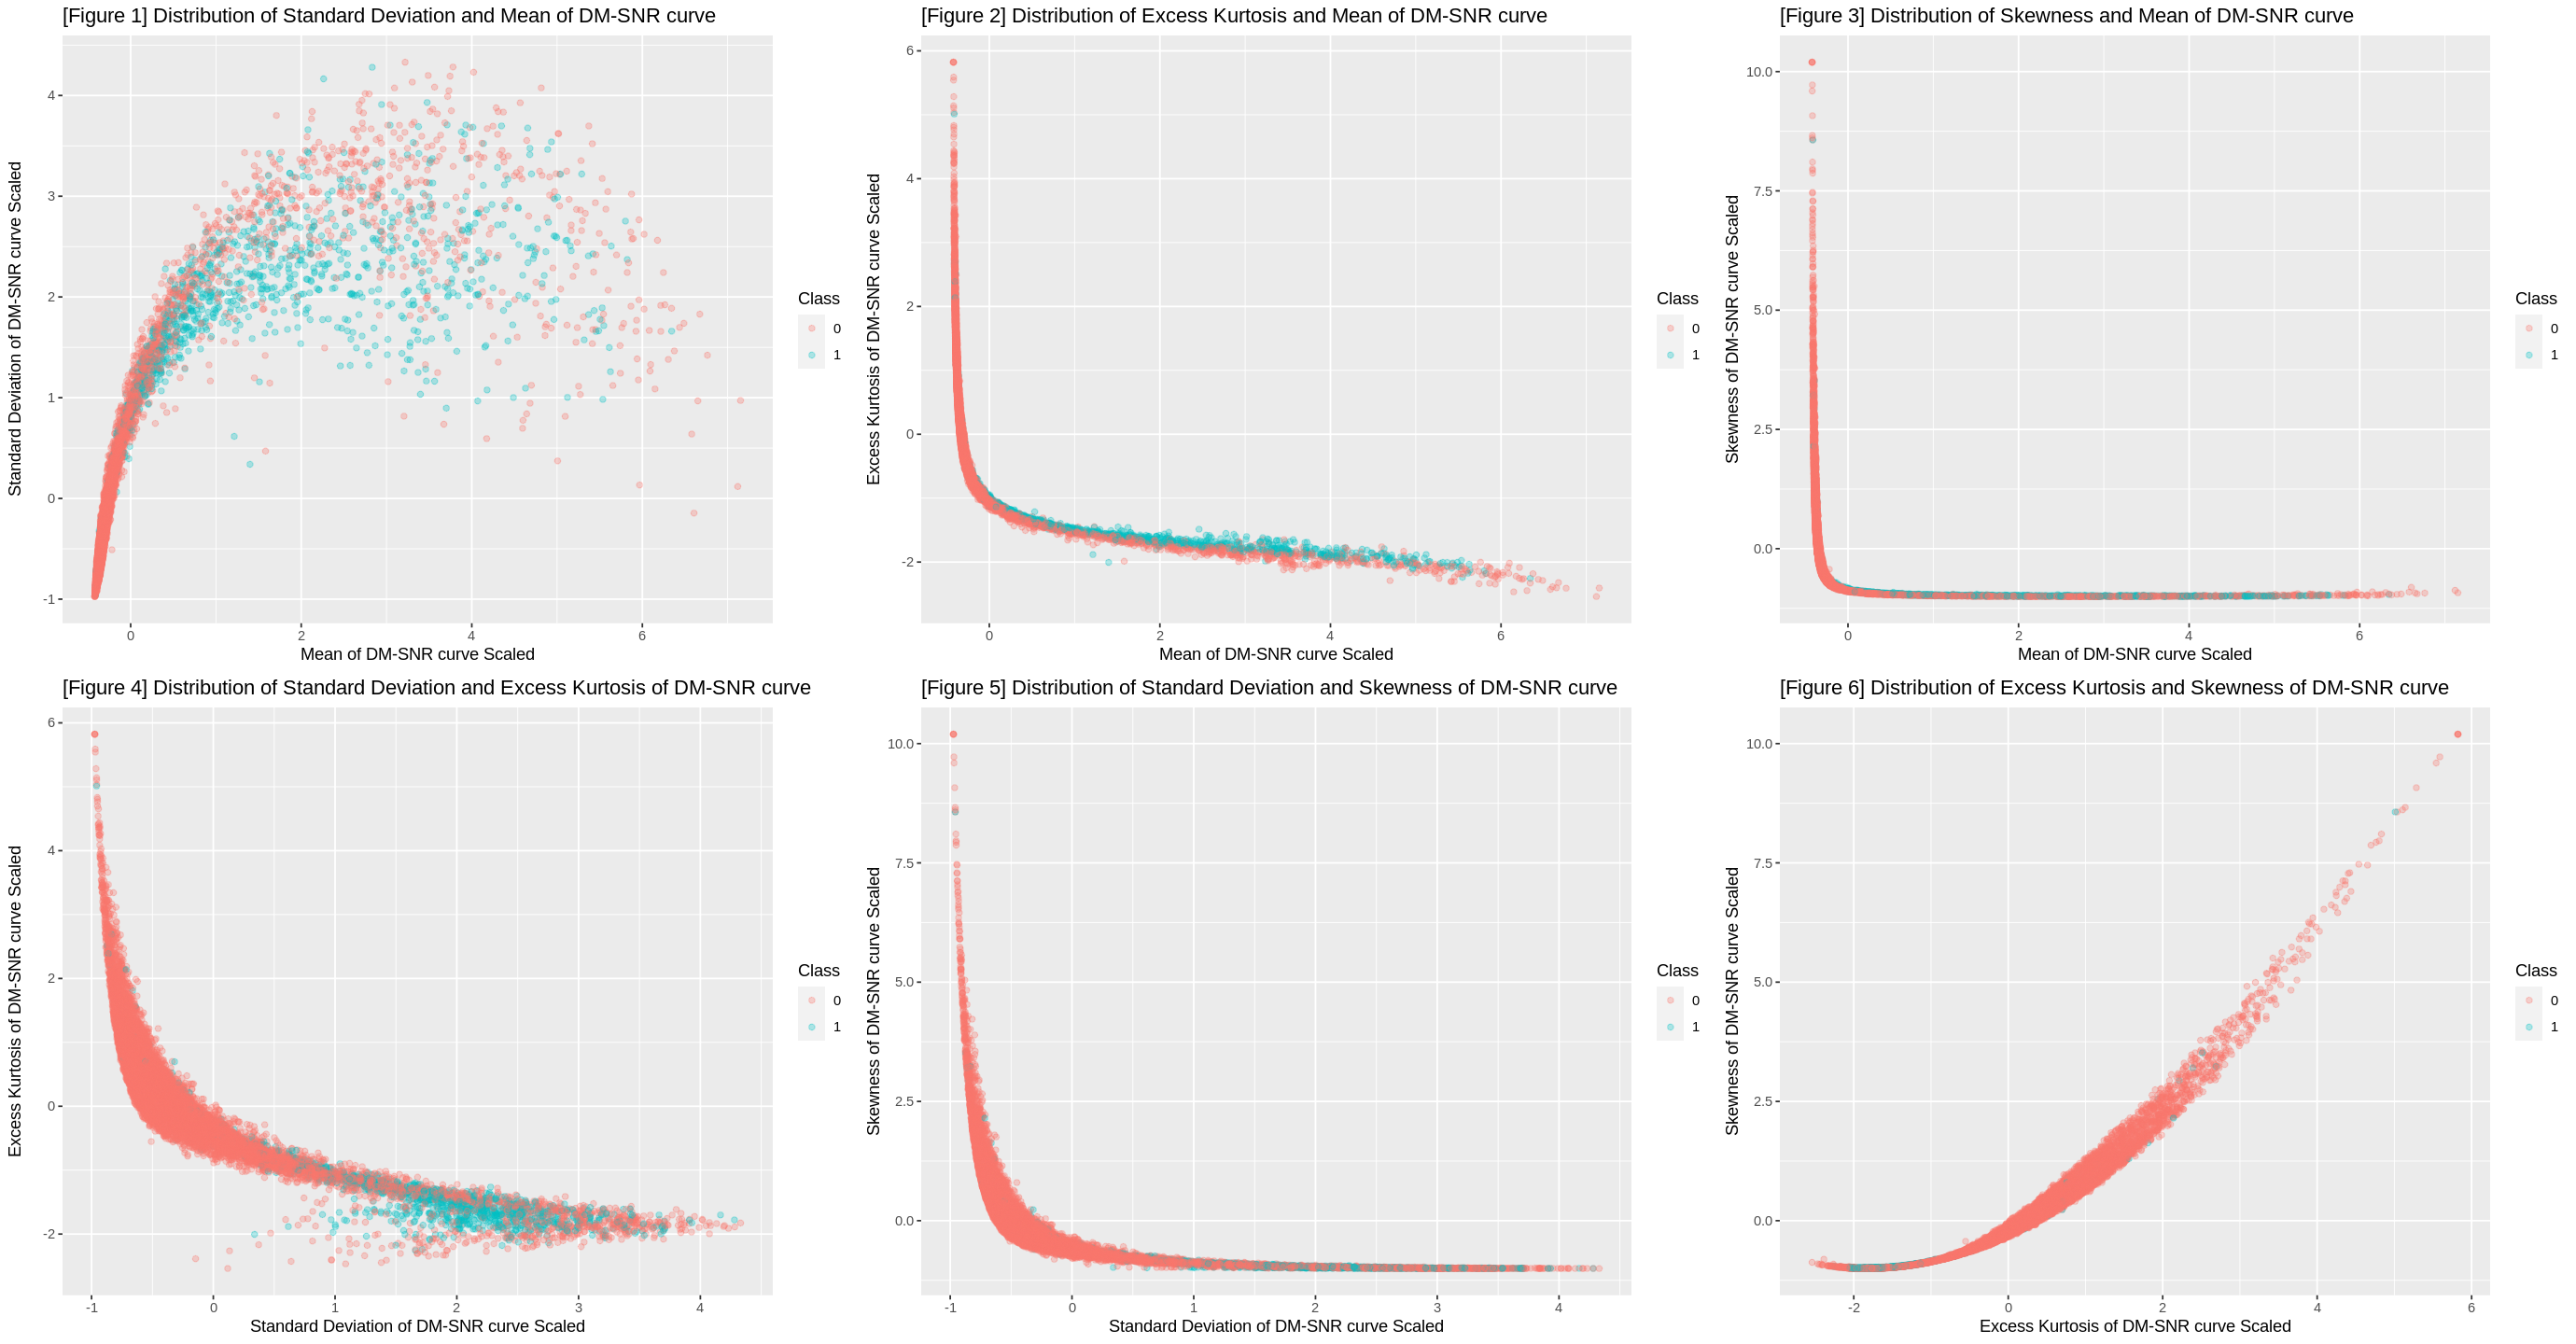

In [9]:
options(repr.plot.width = 23, repr.plot.height = 12)

mean_dmsnr_vs_std_dmsnr <- pulsar_training |>
                        ggplot(aes(x=mean_dmsnr_scaled, y=std_dmsnr_scaled, color=class)) +
                        geom_point(alpha = 0.3) +
                        labs(x="Mean of DM-SNR curve Scaled",
                             y="Standard Deviation of DM-SNR curve Scaled",
                             color="Class",
                             title="[Figure 1] Distribution of Standard Deviation and Mean of DM-SNR curve") +
                        theme(text = element_text(size = 11))

mean_dmsnr_vs_ek_dmsnr <- pulsar_training |>
                        ggplot(aes(x=mean_dmsnr_scaled, y=ek_dmsnr_scaled, color=class)) +
                        geom_point(alpha = 0.3) +
                        labs(x="Mean of DM-SNR curve Scaled",
                             y="Excess Kurtosis of DM-SNR curve Scaled",
                             color="Class",
                             title="[Figure 2] Distribution of Excess Kurtosis and Mean of DM-SNR curve") +
                        theme(text = element_text(size = 11))

mean_dmsnr_vs_sk_dmsnr <- pulsar_training |>
                        ggplot(aes(x=mean_dmsnr_scaled, y=sk_dmsnr_scaled, color=class)) +
                        geom_point(alpha = 0.3) +
                        labs(x="Mean of DM-SNR curve Scaled",
                             y="Skewness of DM-SNR curve Scaled",
                             color="Class",
                             title="[Figure 3] Distribution of Skewness and Mean of DM-SNR curve") +
                        theme(text = element_text(size = 11))

std_dmsnr_vs_ek_dmsnr <- pulsar_training |>
                        ggplot(aes(x=std_dmsnr_scaled, y=ek_dmsnr_scaled, color=class)) +
                        geom_point(alpha = 0.3) +
                        labs(x="Standard Deviation of DM-SNR curve Scaled",
                             y="Excess Kurtosis of DM-SNR curve Scaled",
                             color="Class",
                             title="[Figure 4] Distribution of Standard Deviation and Excess Kurtosis of DM-SNR curve") +
                        theme(text = element_text(size = 11))

std_dmsnr_vs_sk_dmsnr <- pulsar_training |>
                        ggplot(aes(x=std_dmsnr_scaled, y=sk_dmsnr_scaled, color=class)) +
                        geom_point(alpha = 0.3) +
                        labs(x="Standard Deviation of DM-SNR curve Scaled",
                             y="Skewness of DM-SNR curve Scaled",
                             color="Class",
                             title="[Figure 5] Distribution of Standard Deviation and Skewness of DM-SNR curve") +
                        theme(text = element_text(size = 11))

ek_dmsnr_vs_sk_dmsnr <- pulsar_training |>
                        ggplot(aes(x=ek_dmsnr_scaled, y=sk_dmsnr_scaled, color=class)) +
                        geom_point(alpha = 0.3) +
                        labs(x="Excess Kurtosis of DM-SNR curve Scaled",
                             y="Skewness of DM-SNR curve Scaled",
                             color="Class",
                             title="[Figure 6] Distribution of Excess Kurtosis and Skewness of DM-SNR curve") +
                        theme(text = element_text(size = 11))

plot_grid(
     mean_dmsnr_vs_std_dmsnr, mean_dmsnr_vs_ek_dmsnr, mean_dmsnr_vs_sk_dmsnr, std_dmsnr_vs_ek_dmsnr, std_dmsnr_vs_sk_dmsnr, ek_dmsnr_vs_sk_dmsnr,
     align="hv"
 )

NULL

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



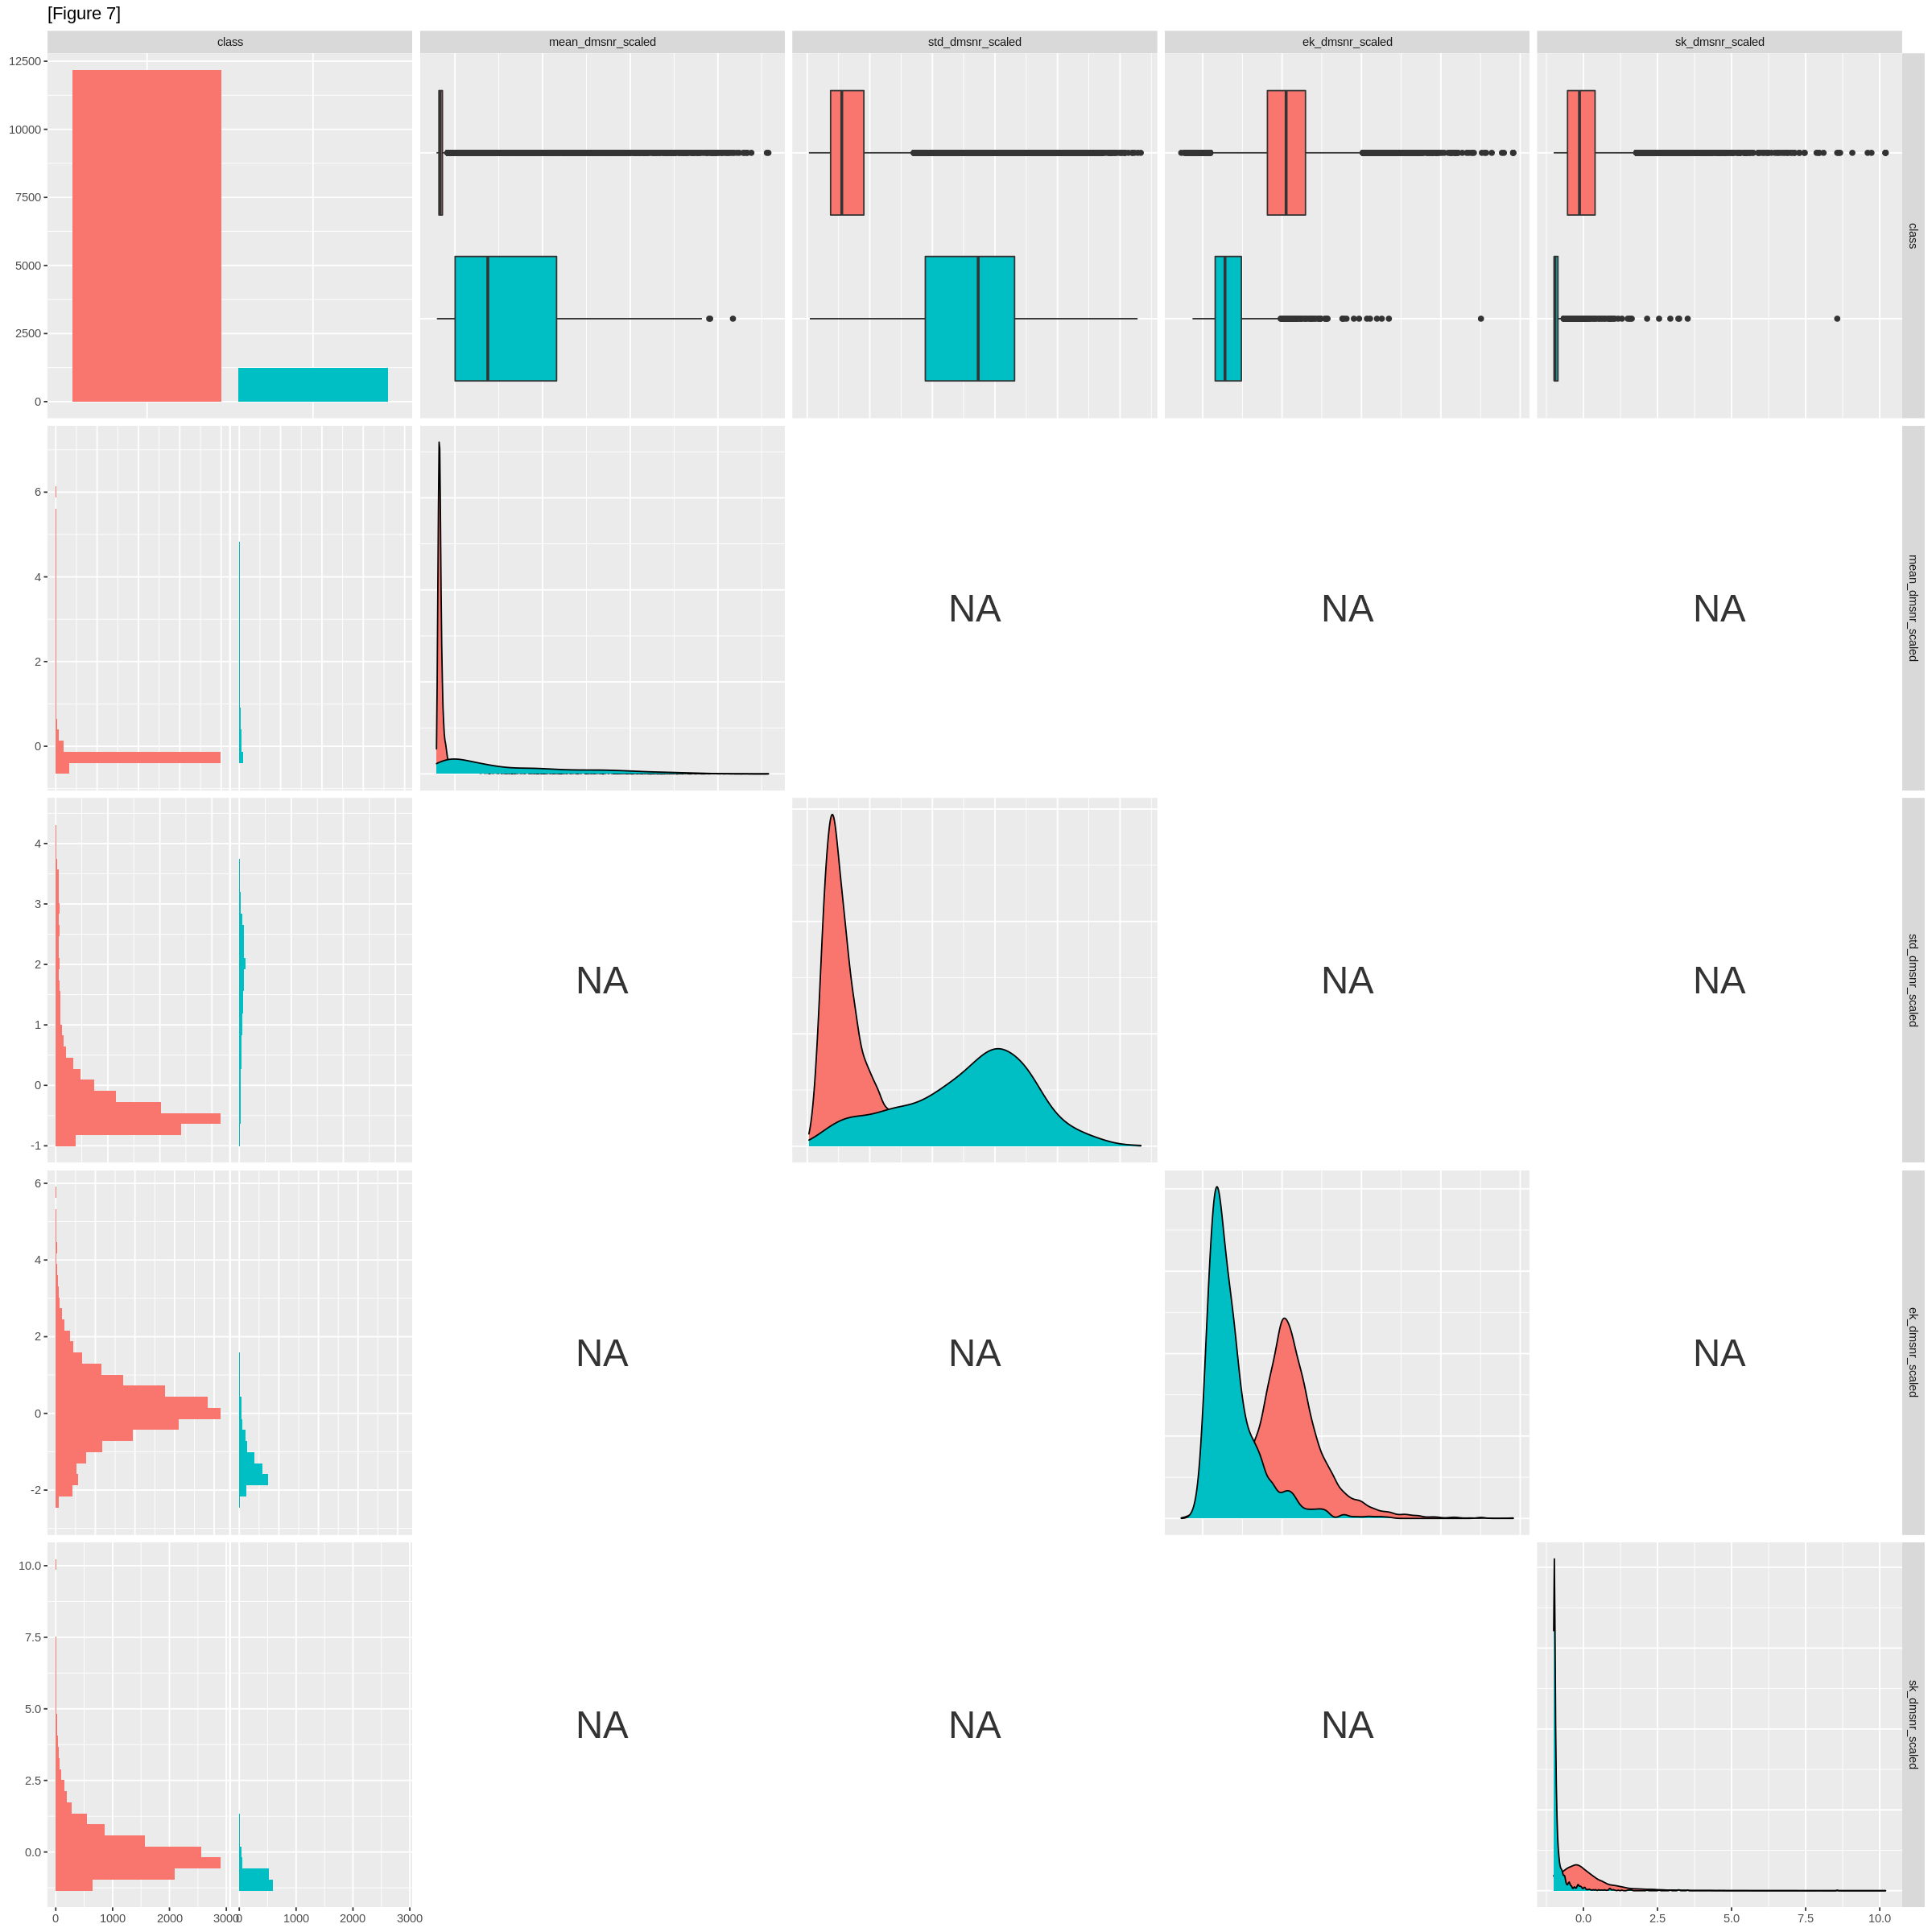

In [10]:
options(repr.plot.width = 20, repr.plot.height = 20)

pairs_plot <- pulsar_training |>
                ggpairs(aes(color=class)) +
                ggtitle("[Figure 7]")
                labs(color=class) +
                theme(text=element_text(size=30))
 
pairs_plot

### Analyzing the graphs and choosing the final predictor variables

In the plots above, we see that the scatters of all the predictors have minuscule overlap between our two classes. Thus, we can go ahead and choose all four of these as our final predictor variables, namely mean_ip, std_ip, ek_ip and sk_ip. Even the box plots in the second image show that the overlap between the two classes for the same variable are very small and that these four predictors should be ideal for training our model with. We want to decrease the overlap between the two classes for all variables as to get more distinct and significant predictors. 

Moreover, we notice in the top right bar graph of the second image between the two classes that the class 1 has very few instances compared to class 2. This rarity of class 1 can make the model more biased towards predicting the class 0 more, thus we will have to fix this issue by upsampling the class 1.

## Training the model

Now, we use $K$-nearest neighbors classification and cross validation of 5 folds in order to train our data. Firstly, we will tune the number of neighbors to find the ideal value for $K$. We will thus test for all values of $K$ from 1 to 100 in steps of 10.

In [11]:
pulsar_recipe <- recipe(class ~ mean_dmsnr_scaled, std_dmsnr_scaled, ek_dmsnr_scaled, sk_dmsnr_scaled, data=pulsar_training) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

knn_tune <- nearest_neighbor(weight_func="rectangular", neighbors=tune()) |>
                        set_engine("kknn") |>
                        set_mode("classification")

pulsar_vfold <- vfold_cv(pulsar_training, v=5, strata=class)

gridvals <- tibble(neighbors=seq(from=1, to=100, by=10))

pulsar_workflow <- workflow() |>
                       add_recipe(pulsar_recipe) |>
                       add_model(knn_tune) |>
                       tune_grid(resamples=pulsar_vfold, grid=gridvals) |>
                       collect_metrics()

knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


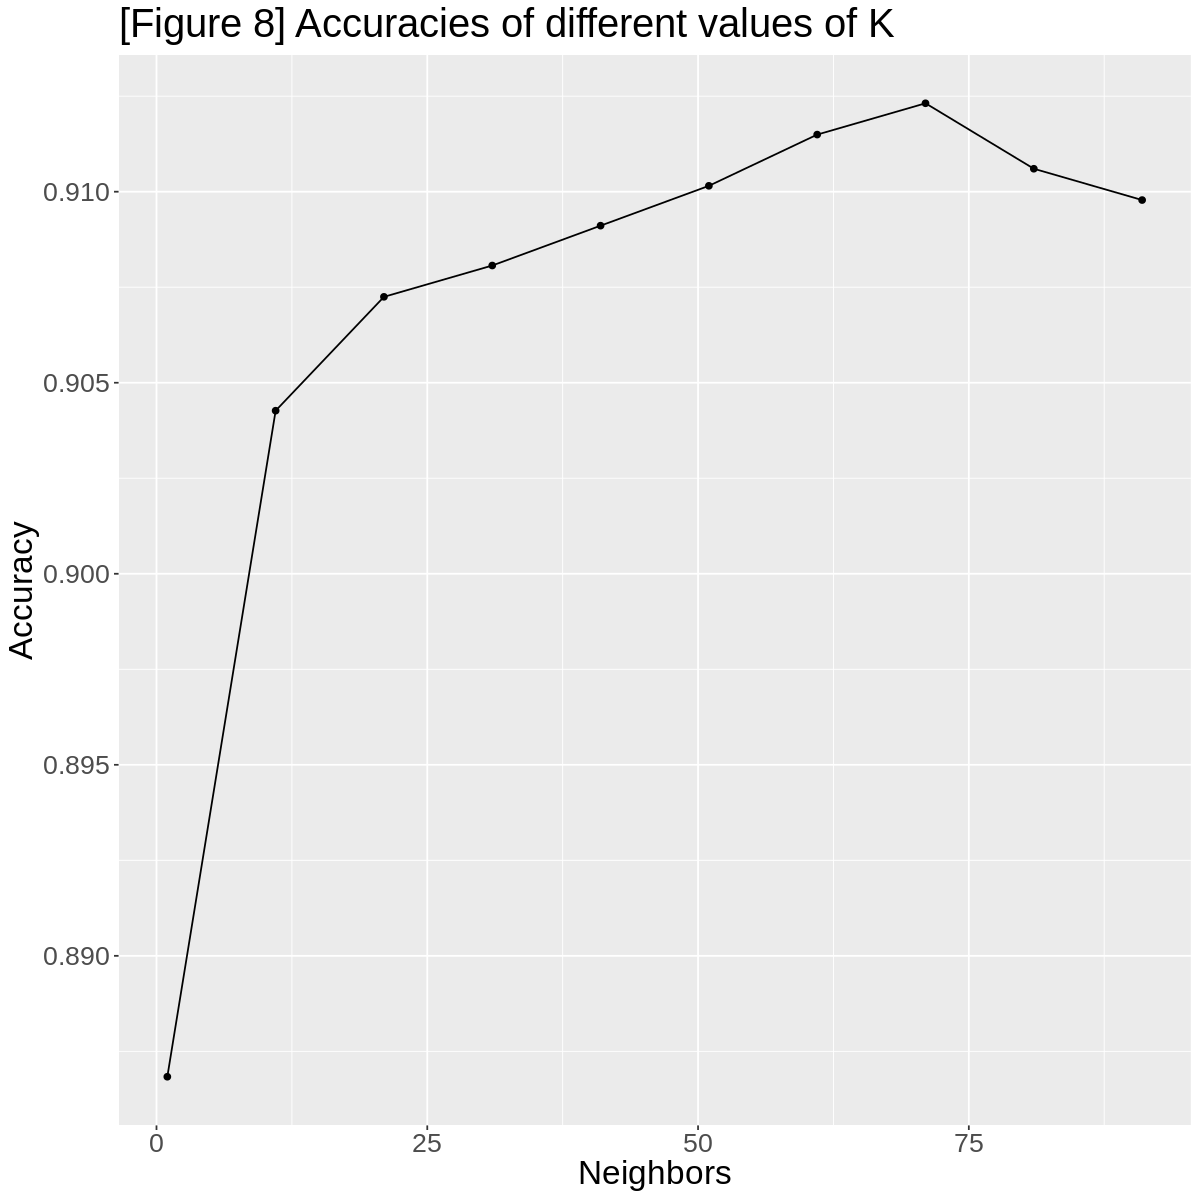

In [12]:
options(repr.plot.width = 10, repr.plot.height = 10)

accuracies <- pulsar_workflow |>
                  filter(.metric == "accuracy") |>
                  select(neighbors, mean)

accuracy_plot <- ggplot(accuracies, aes(x=neighbors, y=mean)) +
                     geom_line() +
                     geom_point() +
                     labs(x = "Neighbors", y = "Accuracy", 
                          title = "[Figure 8] Accuracies of different values of K") +
                     theme(text = element_text(size = 20))

accuracy_plot

Above, we see that the accuracy is the highest for the values of $K$ between 60 and 80. Thus, we can test for values for $K$ between 0 and 20 using smaller intervals to get a better and more precise value.

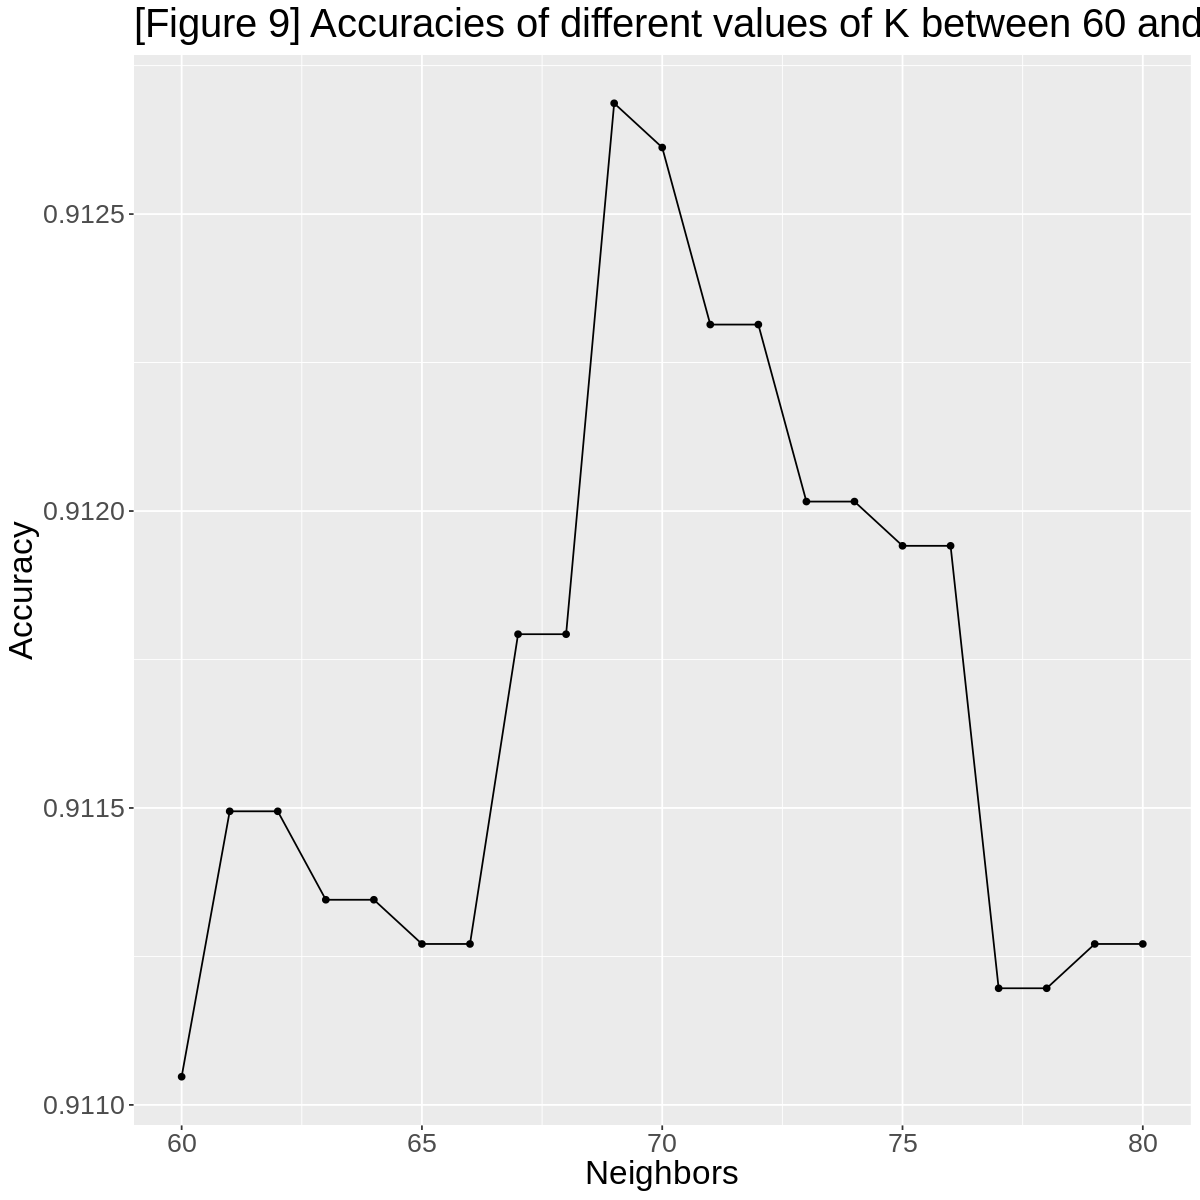

In [13]:
options(repr.plot.width = 10, repr.plot.height = 10)

gridvals2 <- tibble(neighbors=seq(from=60, to=80, by=1))

pulsar_workflow_2 <- workflow() |>
                       add_recipe(pulsar_recipe) |>
                       add_model(knn_tune) |>
                       tune_grid(resamples=pulsar_vfold, grid=gridvals2) |>
                       collect_metrics()

accuracies2 <- pulsar_workflow_2 |>
                  filter(.metric == "accuracy") |>
                  select(neighbors, mean)

accuracy_plot_2 <- ggplot(accuracies2, aes(x=neighbors, y=mean)) +
                     geom_line() +
                     geom_point() +
                     labs(x = "Neighbors", y = "Accuracy", 
                          title = "[Figure 9] Accuracies of different values of K between 60 and 80") +
                     theme(text = element_text(size = 20))

accuracy_plot_2

Now we see that the maximum accuracy occurs when $K$ is 69. Thus, we can go ahead using this value of $K$ with the same model.

In [15]:
knn_tune_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 69) |>
                set_engine("kknn") |>
                set_mode("classification")

pulsar_fit <- workflow() |>
                add_recipe(pulsar_recipe) |>
                add_model(knn_tune_2) |>
                fit(data = pulsar_training)

Now, we are ready to predict the class labels for our test set.

## Making the predictions

In [16]:
pulsar_predictions <- predict(pulsar_fit , pulsar_testing) |>
       bind_cols(pulsar_testing)


print("Table 8")
head(pulsar_predictions)

[1] "Table 8"


.pred_class,class,mean_dmsnr_scaled,std_dmsnr_scaled,ek_dmsnr_scaled,sk_dmsnr_scaled
<fct>,<fct>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
0,0,-0.3220980,-0.2353216,-0.1259926,-0.3913625
0,0,-0.3724816,-0.6050896,0.5144574,0.2491331
0,0,-0.3726235,-0.7354026,0.8141224,0.8513931
0,0,-0.3768221,-0.7320593,1.1238940,1.1132819
0,0,-0.2962254,-0.1685234,-0.2996806,-0.4936253
0,0,-0.1470038,0.5897874,-0.8015214,-0.7846957


Now, we calculate the accuracy of our predictions.

## Calculating the accuracies

In [17]:
pulsar_accuracy <- pulsar_predictions |>
                     metrics(truth = class, estimate = .pred_class) 

print("Table 9")
pulsar_accuracy

[1] "Table 9"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9139665
kap,binary,0.3958299


Let's have a look at the confusion matrix as well.

In [18]:
pulsar_mat <- pulsar_predictions |> 
                conf_mat(truth = class, estimate = .pred_class)

print("Table 10")
pulsar_mat

[1] "Table 10"


          Truth
Prediction    0    1
         0 3938  246
         1  139  152

## Visualizing our accuracy of our model

We can now try and visualize the accuracy of our predictions by plotting all predictors of the testing data and the predictions to see how similar both are. For this instance, let's just see the comparisons between the plots of mean integrated profile versus the standard deviation of the integrated profile.

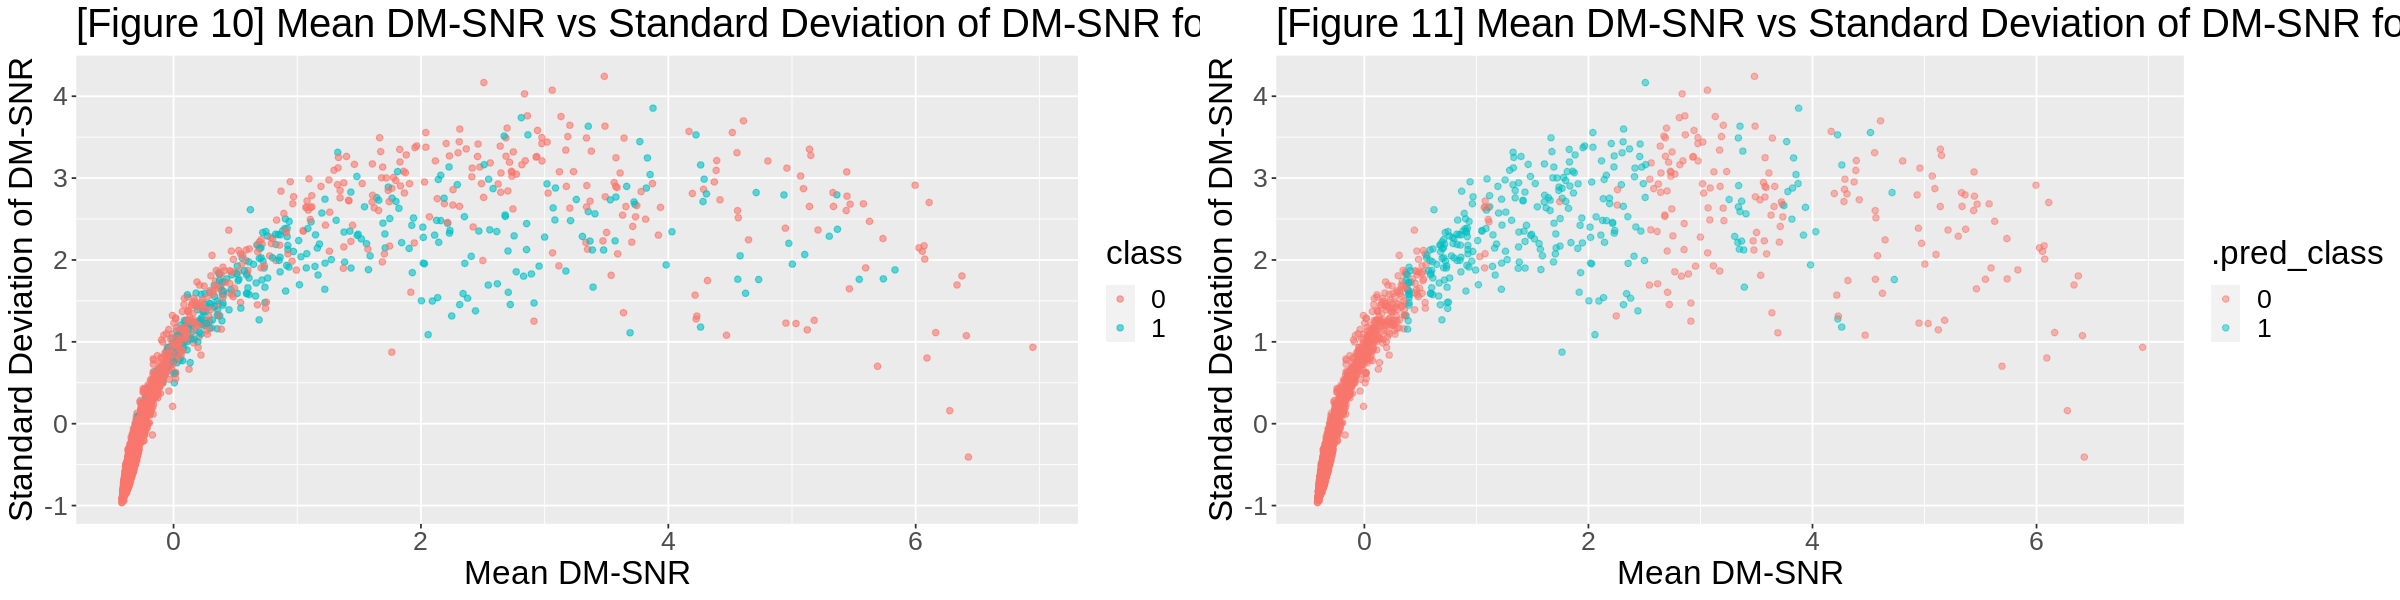

In [20]:
options(repr.plot.width = 20, repr.plot.height = 5)

plot_mean_dmsnr_std_dmsnr_test <- ggplot(pulsar_testing, aes(x=mean_dmsnr_scaled, y=std_dmsnr_scaled, color=class)) +
                                geom_point(alpha=0.6) +
                                ggtitle('[Figure 10] Mean DM-SNR vs Standard Deviation of DM-SNR for Testing Data') +
                                labs(x= 'Mean DM-SNR', y= 'Standard Deviation of DM-SNR') +
                                theme(text=element_text(size=20))

plot_mean_dmsnr_std_dmsnr_pred <- ggplot(pulsar_predictions, aes(x=mean_dmsnr_scaled, y=std_dmsnr_scaled, color=.pred_class)) +
                                geom_point(alpha = 0.5) +
                                ggtitle('[Figure 11] Mean DM-SNR vs Standard Deviation of DM-SNR for Predictions') +
                                labs(x= 'Mean DM-SNR', y= 'Standard Deviation of DM-SNR') +
                                theme(text=element_text(size=20))

plot_grid(plot_mean_dmsnr_std_dmsnr_test, plot_mean_dmsnr_std_dmsnr_pred)

Now comparing the plots between Excess Kurtosis and Mean.

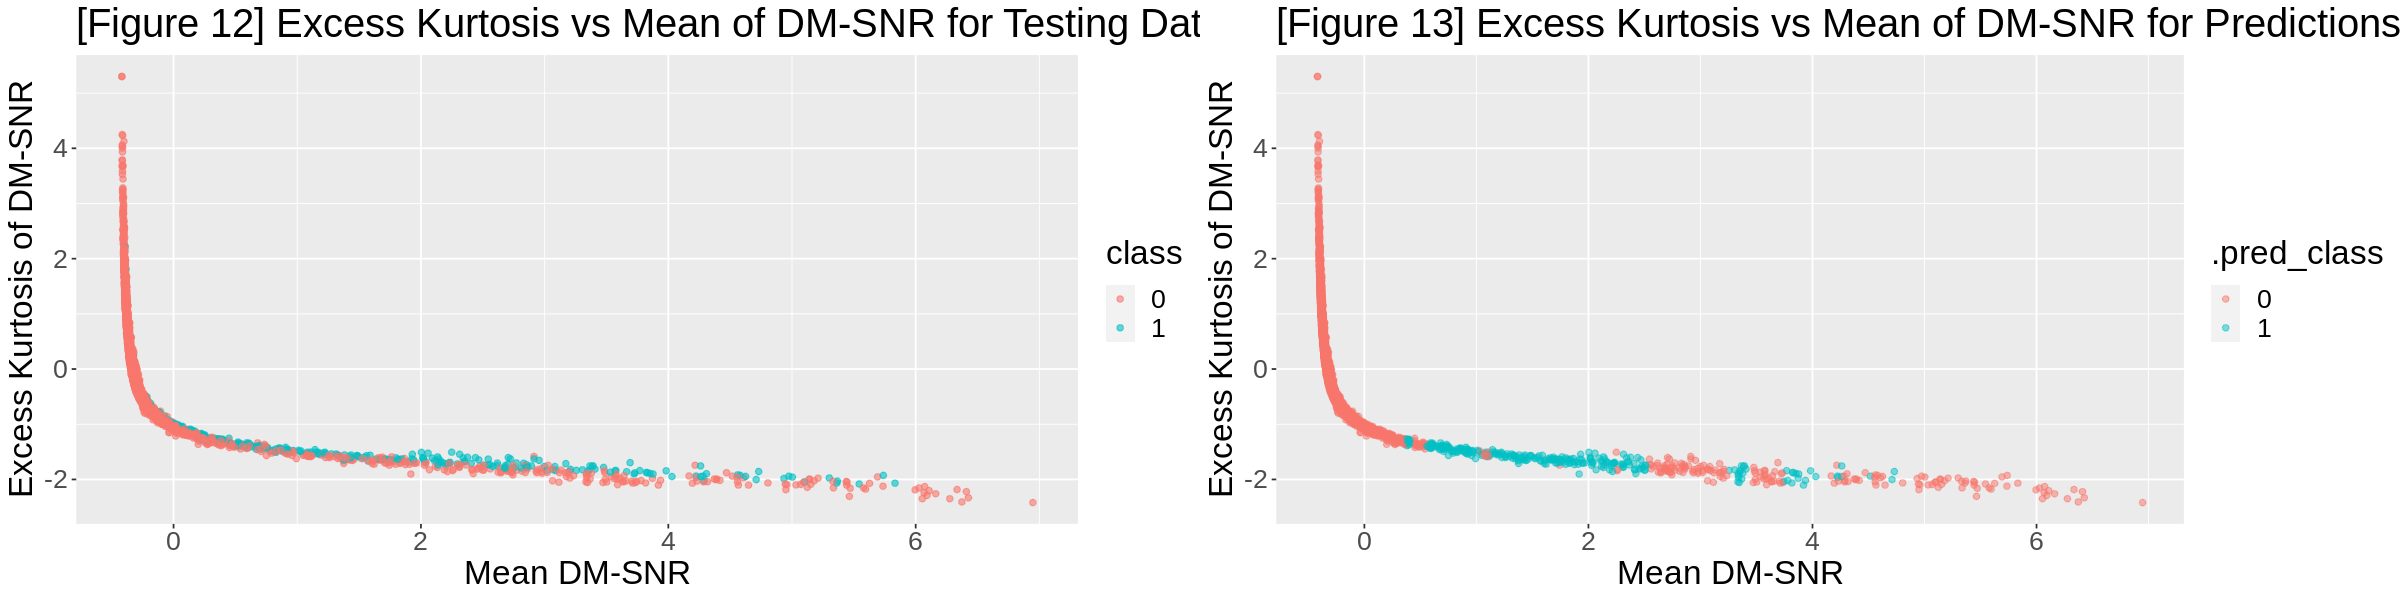

In [21]:
options(repr.plot.width = 20, repr.plot.height = 5)

plot_mean_dmsnr_ek_dmsnr_test <- ggplot(pulsar_testing, aes(x=mean_dmsnr_scaled, y=ek_dmsnr_scaled, color=class)) + 
                                geom_point(alpha=0.6) + 
                                ggtitle('[Figure 12] Excess Kurtosis vs Mean of DM-SNR for Testing Data') +
                                labs(x= 'Mean DM-SNR', y= 'Excess Kurtosis of DM-SNR') +
                                theme(text=element_text(size=20))

plot_mean_dmsnr_ek_dmsnr_pred <- ggplot(pulsar_predictions, aes(x=mean_dmsnr_scaled, y=ek_dmsnr_scaled, color=.pred_class)) + 
                                geom_point(alpha = 0.5) + 
                                ggtitle('[Figure 13] Excess Kurtosis vs Mean of DM-SNR for Predictions') +
                                labs(x= 'Mean DM-SNR', y= 'Excess Kurtosis of DM-SNR') +
                                theme(text=element_text(size=20))

plot_grid(plot_mean_dmsnr_ek_dmsnr_test, plot_mean_dmsnr_ek_dmsnr_pred)

Now comparing the plots between Skewness and Mean.

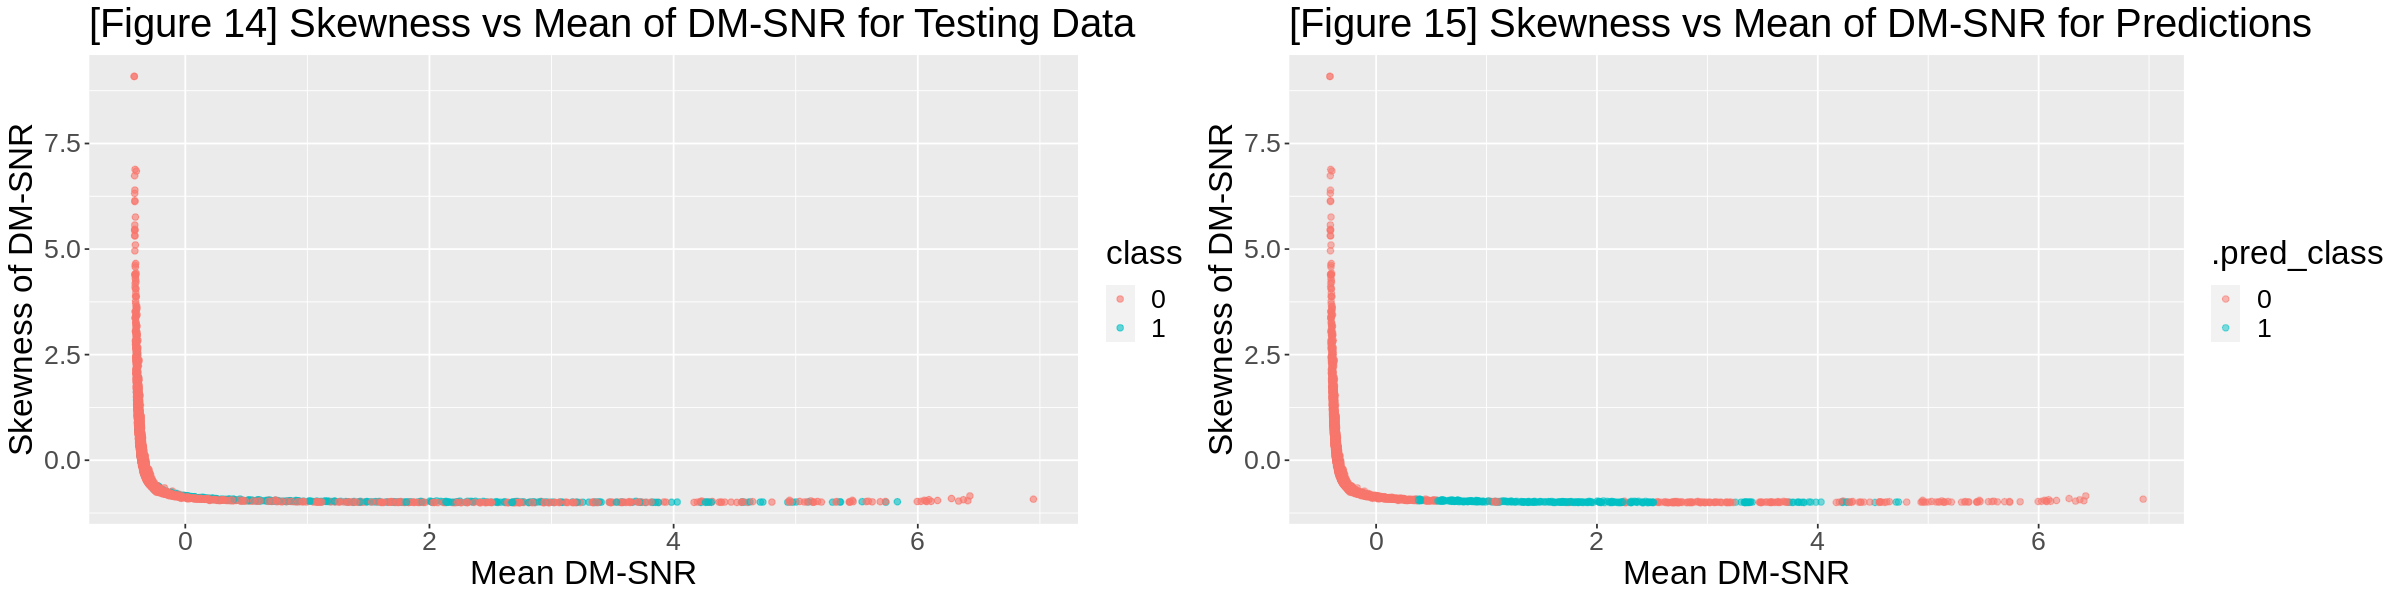

In [22]:
options(repr.plot.width = 20, repr.plot.height = 5)

plot_mean_dmsnr_sk_dmsnr_test <- ggplot(pulsar_testing, aes(x=mean_dmsnr_scaled, y=sk_dmsnr_scaled, color=class)) + 
                                geom_point(alpha=0.6) + 
                                ggtitle('[Figure 14] Skewness vs Mean of DM-SNR for Testing Data') +
                                labs(x= 'Mean DM-SNR', y= 'Skewness of DM-SNR') +
                                theme(text=element_text(size=20))

plot_mean_dmsnr_sk_dmsnr_pred <- ggplot(pulsar_predictions, aes(x=mean_dmsnr_scaled, y=sk_dmsnr_scaled, color=.pred_class)) + 
                                geom_point(alpha = 0.5) + 
                                ggtitle('[Figure 15] Skewness vs Mean of DM-SNR for Predictions') +
                                labs(x= 'Mean DM-SNR', y= 'Skewness of DM-SNR') +
                                theme(text=element_text(size=20))

plot_grid(plot_mean_dmsnr_sk_dmsnr_test, plot_mean_dmsnr_sk_dmsnr_pred)

## References

Dataset:
- R. J. Lyon, B. W. Stappers, S. Cooper, J. M. Brooke, J. D. Knowles, Fifty Years of Pulsar Candidate Selection: From simple filters to a new principled real-time classification approach, Monthly Notices of the Royal Astronomical Society 459 (1), 1104-1123, DOI: 10.1093/mnras/stw656
https://archive.ics.uci.edu/ml/datasets/HTRU2

Papers:
- R. J. Lyon, 'Why Are Pulsars Hard To Find?', PhD Thesis, University of Manchester, 2016.
- D. R. Lorimer and M. Kramer, 'Handbook of Pulsar Astronomy', Cambridge University Press, 2005.